# Part B: Sampling from probability distributions using MCMC methods

In this part we will use Gibbs sampling to draw samples from a 2D Gaussian distribution. This is illustrated in the book in Figure 10.12 and an outline of the Gibbs sampling algorithm is also [provided](Documentation/GibbsSampling_Cookbook.pdf) in case you want it. After running the code and understanding what it is doing, there are two parts to implement:

1. [Defining](#Joint-distribution) the conditional distribution given a specific $x$ or $y$ value.
2. [Implementing](#Univariate-distribution) the sampling method for this conditional distribution.

**Note**: this is not the usual way to sample from a multivariate Gaussian! A much more efficient way to do this is to take:

<p style="text-align: center;">
`sample = mean + cholesky(covariance) @ randn(2,1)`
</p>

Where the routine `'cholesky'` is the cholesky decomposition - a matrix square root so that $L = cholesky(A) \implies LL^T = A$. Remember also that `@` denotes matrix multiplication in Python.
This is implemented in the [`Gaussian2D`](#Define-models) class for reference but is not necessary (and should not be used!) for this part.

### Import modules

A class ```Position``` is also defined to track the $(x, y)$ coordinates of samples

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.linalg import cholesky
from numpy.random import randn

from utils import arguments_mutually_exclusive
from visualisation import draw_gaussian

Position = namedtuple('Position', ('x', 'y'))

# Define models

### Joint distribution
**TO DO:** For a specific $x$ _or_ $y$ value the `conditional` method should return a distribution that can be sampled from. Currently it just returns the unit normal, so you should replace this with the correct conditional distribution for both cases (look at the notes for the Gaussian distribution).

In [2]:
class Gaussian2D:
    '''
    Class to define a Gaussian distribution in two dimensions
    Attributes:
     - mean: mean of the distribution
     - covariance: covariance matrix of the distribution
    '''
    def __init__(self, mean, covariance):
        '''
        Object creation:
         - mean: mean of the distribution
         - covariance: covariance matrix of the distribution
        '''
        self.mean = np.array(mean)
        self.covariance = np.array(covariance)
    
    @property
    def parameters(self):
        return self.mean, self.covariance
        
    @arguments_mutually_exclusive
    def conditional(self, x=None, y=None):
        '''
        Method to return the conditional distribution given the value along the other dimension
        '''
        mu1,mu2 = self.mean
        (sigma11,sigma12),(sigma21,sigma22) = self.covariance
        if y is not None:

            # TO DO: replace this
            mean = mu1 + sigma12 *(1/sigma22)*(y-mu2)
            std = np.sqrt(sigma11 - sigma12*(1/sigma22)*sigma12)
            return Gaussian1D(mean,std)
        if x is not None:
            # TO DO: replace this
            mean = mu2 + sigma12*(1/sigma11)*(x-mu1)
            std = np.sqrt(sigma22 - sigma12*(1/sigma11)*sigma12)
            return Gaussian1D(mean,std)
            
    def sample(self):
        '''
        Method to sample from the distribution
        '''
        return self.mean.reshape(2, 1) + cholesky(self.covariance) @ randn(2,1)

### Univariate distribution
**TO DO:** Sample from the gaussian distribution in one dimension _using the parameters given_ (mean,std). You can use `randn` for this.

In [3]:
class Gaussian1D:
    '''
    Class to define a Gaussian distribution in one dimension
    Attributes:
     - mean: mean of the distribution
     - std: standard deviation of the distribution
     '''
    def __init__(self, mean = 0, std =1):
        '''
        Object creation:
         - mean: mean of the distribution
         - std: standard deviation of the distribution
        '''
        self.mean = mean
        self.std = std
        
    def sample(self):
        '''
        Method to sample from the distribution
        '''
        data = self.std*randn() + self.mean
        #data_minus_mean = data - mean
        #before_exp = 1/np.power(2*np.pi*std**2, 0.5)
        #inside_exp = -0.5*(data_minus_mean)**2/std**2
        #after_exp = np.exp(inside_exp)
        #like = before_exp * after_exp
        # TO DO: replace this
        return data

# Generate samples
Having defined the type of model we're using, here we define the actual distribution that we're sampling from:

In [4]:
joint_distribution = Gaussian2D(mean=[1, 2], covariance=[[1.6370, 0.4210], [0.4210, 0.1598]])
current = Position(x=0, y=0)

In [5]:
mean=[1, 2]
covariance=[[1.6370, 0.4210], [0.4210, 0.1598]]
print(mean[1])

2


### Generate from Markov Chain
Starting from the initial position, every new position should be a (correlated) sample from our distribution. Since we are sampling from the conditional distributions we will only be updating _either_ $x$ or $y$ at each step.

In [10]:
chain = [current]

for sample in range(1000):
    # conditional distribution in x direction given current y
    sample_x = joint_distribution.conditional(y=current.y).sample()

    current = Position(sample_x, current.y)
    chain.append(current)

    # conditional distribution in y direction given current x
    sample_y = joint_distribution.conditional(x=current.x).sample()

    current = Position(current.x, sample_y)
    chain.append(current)

# Visualise samples
If the Gibbs sampling is working correctly, the samples should tend to be drawn from inside the black ellipse shown. This represents the distance of two standard deviations from the mean, and so the vast majority of the samples should come from within this area

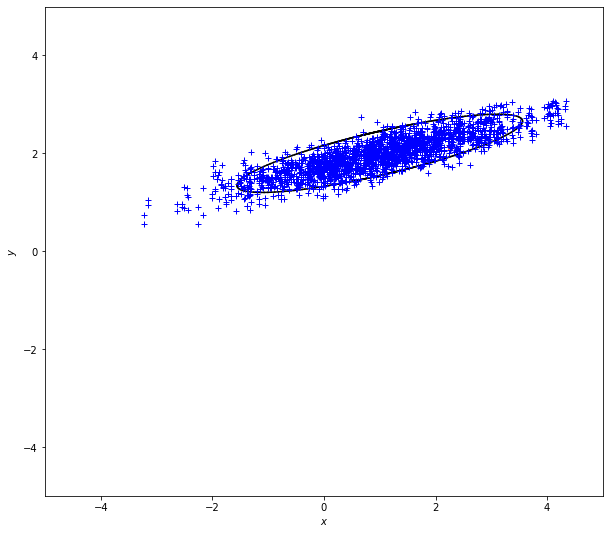

In [11]:
draw_gaussian(*joint_distribution.parameters)

first_point = chain[0]
plt.plot(*first_point, '*r')

x, y = zip(*chain)
plt.plot(x, y, '+b');

## TO DO 
Change the plotting code to only display markers (`+`) rather than a line (`-`) between points and use this method to generate 1000 samples from the Gaussian. It should become clearer that the distribution of locations of the points matches the specified Gaussian distribution.